### Setup

In [1]:
#Generic import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
import pytreegrav
from pytreegrav import Accel, Potential
from scipy import interpolate
from scipy import signal
print(f'Pytorch version {torch.__version__}')

Pytorch version 2.0.1


In [2]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

Pytorch version 2.0.1
Pytorch version 2.0.1


In [3]:
potential_type = 'plummer' #used to select potential {'plummer','?'}
unit_type = 'dimensionless' #used to select units {'galactic','dimensionless'}
orbited = False

G, M, b = 1, 1, 1
#G = constant.G.to(u.kpc*u.km**2/u.solMass/u.s**2)/(u.kpc*u.km**2/u.solMass/u.s**2) #Gravitonal Constant in desired units
#M = 1e4 #Total Mass of the System
#b = 1.5 #Scale Radius
m = 1 #Mass of a typical particle

np.save('G',G)
np.save('M',M)
np.save('b',b)

#Lambda functions for various potentials {KE ,PE, qpdf, vdlytic, vesc}
if potential_type == 'plummer':
    PE = lambda G, M, b, r : -(G*M) / (b**2 + r**2)**(1/2) #Potential Energy
    KE =  lambda m, v : (m/2)*(v**2) #Kinetic Energy
    qpdf = lambda q: ((7*np.pi)/512)*np.square(q)*np.power(np.subtract(1,np.square(q)),7/2) #Normalized velocity probability distribution function
    vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2))) #Analytic velocity dispersion
    vesc = lambda G, M, b, r: np.sqrt(2*G*M/np.sqrt(b**2+np.square(r))) #Escape velocity
    df_norm = lambda G, M, b: (24 * b**2 * np.sqrt(2.) ) / (7. * G**5 * M**4 * np.pi**3) #Normalization for distibution function
    rholytic = lambda M, b, r: ((3 * M) / (4 * np.pi * b**3)*(1+(r/b)**2)**(-5/2))
    Mlytic = lambda M, b, r: (M * r**3) / (r**2 + b**2)**(3/2)
    dPhilytic = lambda G, M, b, r: (G*M*r)/np.power(b**2+r**2,1.5)

if potential_type == '?':
    print('Update these definitions')


In [16]:
#Generates the true distribution function.
def df_ideal(q, p):
    r2 = torch.sqrt(torch.sum(q**2, axis=1))
    v2 = torch.sqrt(torch.sum(p**2, axis=1))
    G = float(np.load('G.npy'))
    M = np.load('M.npy')
    b = np.load('b.npy')

    if potential_type == 'plummer':
        E = PE(G,M,b,r2)+KE(m,v2)
        f = torch.clamp(-E, 0, np.inf)**(7/2)

    A = df_norm(G,M,b)

    return A * f


def analytic_df(q,p,G,M,b):
    x,y,z = q.T[0],q.T[1],q.T[2]
    vx,vy,vz = p.T[0],p.T[1],p.T[2]
    E = .5*(vx**2+vy**2+vz**2)-((G*M)/np.sqrt(b**2+x**2 + y**2 + z**2))
    Cdx = -np.power(-E,2.5)*(12 * np.sqrt(2.) * b**2 )*(1/(G**4 * M**3 * np.pi**3))*(1/np.power(b**2+x**2+y**2+z**2,1.5))
    Cdv = -np.power(-E,2.5)*(12 * np.sqrt(2.) * b**2 )*(1/(G**5 * M**4 * np.pi**3))
    dx = Cdx*[x,y,z]
    dv = Cdv*[vx,vy,vz]
    return dx, dv

#Calculates rho(r) assuming spherical symmetry
def rho_est(q):
    x,y,z = q.T[0],q.T[1],q.T[2]
    r0 = np.sqrt(x**2+y**2+z**2)
    N , bin_edges= histogram(r0,bins='blocks')
    r_center = (bin_edges[:-1] + bin_edges[1:])/2
    dr = abs(bin_edges[:-1] - bin_edges[1:])
    V0 = 4 * np.pi * (r_center**2) * dr
    rho = N/V0
    return rho, r_center

#Generates mock data for an idealized plummer sphere.
plummer_sphere = toy_systems.PlummerSphere(G,M,b)
def sample_df(n_samples, max_dist=None):
    """
    Returns phase-space locations sampled from the Plummer sphere
    distribution function. The shape of the output is
    (n_samples, 6).
    """
    #Generates coordinates in phase-space from that lie in a spherical spatial region.
    x,v = plummer_sphere.sample_df(n_samples)
    if max_dist is not None:
        r2 = np.sum(x**2, axis=1)
        idx = (r2 < max_dist**2)
        x = x[idx]
        v = v[idx]
    
    return torch.cat([torch.Tensor(x.astype('f4')), torch.Tensor(v.astype('f4'))], axis=1) , x , v

def pairpot(G,q):
    r0 = np.sqrt(np.sum(q**2,axis=1))
    q0 = np.ones_like(q[:,0])
    Q0 = np.outer(q,q0).reshape(n_samples,3,n_samples)
    Q = Q0.transpose(2,1,0)
    rd0 = np.sqrt(np.sum((Q-Q0)**2,axis = 1))
    rd = rd0[rd0 != 0].reshape(n_samples,n_samples-1)
    Phi0 = -G * np.sum(np.power(rd,-1),axis = 1)
    r, Phi = zip(*sorted(zip(r0, Phi0), key=lambda x: x[0]))
    return r, Phi


def smooth(data,div):
    sdata = np.copy(data)
    for i in range(0,len(data)):
        ifin = len(data)-div
        if i <= div:
            sdata[i] = np.mean(data[i:div])
        elif i >= ifin:
            sdata[i] = np.mean(data[i:ifin])
        elif div < i < ifin:
            sdata[i] = np.mean(data[i-div:i+div])

    return sdata

def dfive(f,r):
    df = []
    #assert(r == sorted(r))
    for i in range(0,len(f)-1):
        if i == 0:
            df += [f[i+1]-f[i]/(r[i+1]-r[i])]
        elif i == len(f)-1:
            df+= [(f[i]-f[i-1])/(r[i]-r[i-1])]
        elif 0 < i < 3 or len(f)-3 < i < len(f)-1:
            df += [(f[i+1]-f[i-1])/(r[i+1]-r[i-1])]
        else:
            df += [(4*(f[i+1]-f[i-1]))/(3*(r[i+1]-r[i-1]))-(f[i+2]-f[i-2])/(3*(r[i+2]-r[i-2]))]
    df += [df[-1]]
    return df

def dfinite(f,r):
    df = []
    for i in range(0,len(f)-1):
        if i == 0:
            df += [(f[i+1]-f[i])/(r[i+1]-r[i])]
        if i == len(f)-1:
            df += [(f[i]-f[i-1])/(r[i]-r[i-1])]
        else:
            df += [(f[i+1]-f[i-1])/(r[i+1]-r[i-1])]
    return df

#Takes a spherical symetric laplacian
def sflacian(f,r):
     df = (r**-2)*np.gradient(np.multiply(r**2,np.gradient(f,r)),r)
     return df

#Tries to fit a polynomial of degree of n and create a curve with grid x from data(x0,y0)
def polyfitter(x0,y0,n,x):
    fits = np.polyfit(x0,y0,n)
    f = np.poly1d(fits)
    curve = f(x)
    return curve

### Code

In [22]:
#Generate Mock Data
n_samples = 10000
data, q, p = sample_df(n_samples)

In [23]:
#Calculate potential from pairwise difference vector coordinates
r, Phi = pairpot(G,q)
r_array = np. asarray(r)

In [26]:
masses = np.ones_like(q.T[0])
rgrav0 = np.sqrt(np.sum(q.T**2,axis=0))
Phigrav0 = Potential(q,masses)
rgrav, Phigrav = zip(*sorted(zip(rgrav0, Phigrav0), key=lambda x: x[0]))
rgrav = np.asarray(rgrav)

In [110]:
window = int(round(n_samples/5))
sPhi = scipy.signal.savgol_filter(Phi, window, 9)

In [99]:
psPhi = polyfitter(r_array, sPhi, 9, r_array)

In [64]:
histN , bin_edges= histogram(r,bins='blocks') #bin data
r_center = (bin_edges[:-1] + bin_edges[1:])/2 #define bin centers
dPhi ,_,__  = stats.binned_statistic(r,Phi, statistic = 'mean', bins = bin_edges)

In [96]:
pPhi = polyfitter(r_center,dPhi,9,r_array)

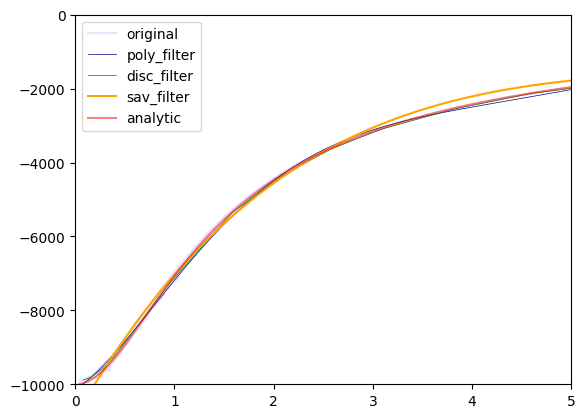

In [111]:
plt.plot(r,Phi, alpha = .1, color = 'blue', label = 'original')
plt.plot(r,pPhi, color = 'navy',lw = .5, label = 'poly_filter')
plt.plot(r_center,dPhi, color = 'green', lw = .5, label = 'disc_filter')
plt.plot(r_array, psPhi, color = 'orange', label = 'sav_filter')
plt.plot(r_array, PE(G,n_samples,b,r_array), color = 'red', alpha =.5, label = 'analytic')
plt.ylim(-10000,0)
plt.xlim(0,5)
plt.legend()

In [108]:
rhop = (1/(4*np.pi*G))*sflacian(pPhi,r_array)
rhod = (1/(4*np.pi*G))*sflacian(dPhi,r_center)
rhoact = (1/(4*np.pi*G))*sflacian(Phi,r_array)
rhos = (1/(4*np.pi*G))*sflacian(sPhi,r_array)
#prhoact = polyfitter(r_array, rhoact, 6, r_array)

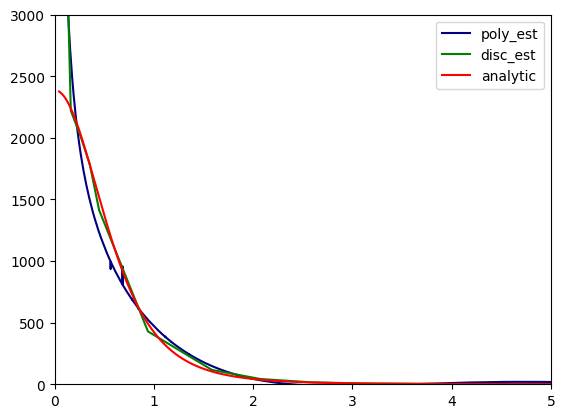

In [114]:
plt.plot(r_array,rhop, label = 'poly_est', color = 'navy')
plt.plot(r_center,rhod, label = 'disc_est', color = 'green')
#plt.plot(r_array,rhos, label = 'sav_est', color = 'orange', alpha = .2)
plt.plot(r_array,rholytic(n_samples,b,r_array), color = 'red', label = 'analytic')
#plt.plot(r_array,rhoact,color = 'purple', label = 'raw', alpha = .1)
#plt.plot(r_array, prhoact, color = 'purple', label = 'poly_raw' )
plt.xlim(0,5)
plt.ylim(0,3000)
plt.legend()

In [77]:
 #Calculate rho
rho, r_center = rho_est(q)

#Calculate the enclosed mass from rho
Menc = []
for i in range(0,len(r_center)-1):
    Menc += [4* np.pi * scipy.integrate.simps((r_center[0:i+1]**2)*rho[0:i+1],r_center[0:i+1])]
Menc += [Menc[-1]]

#Calculate the potential from the enclosed mass and rho
MPot, NPot = [], []
endr = int(len(r_center))
for i in range(0,len(r_center)):
    MPot += [-np.divide(G*Menc[i],r_center[i])]
    NPot += [-np.trapz(rho[i:endr]*r_center[i:endr],r_center[i:endr])]
EPot = np.add(np.multiply(4* G *np.pi,NPot),MPot)


Text(0, 0.5, 'relative error (%)')

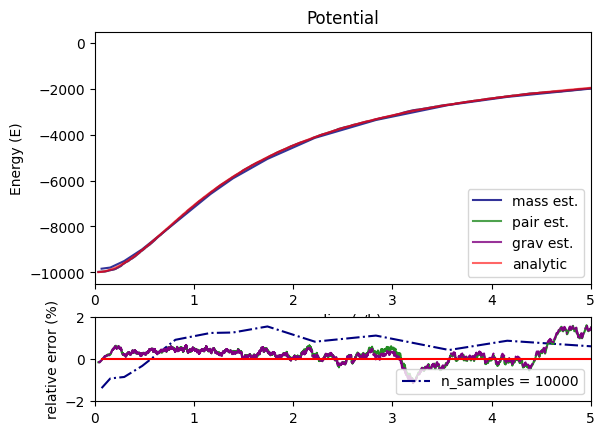

In [79]:
fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
xmax = 5*b
ax[0].plot(r_center,EPot, label = 'mass est.', color = 'navy', alpha = .8)
ax[0].plot(r, sPhi,label = 'pair est.', color = 'forestgreen', alpha = .8)
ax[0].plot(rgrav,sPhigrav,label = 'grav est.', color= 'purple', alpha = .8)
ax[0].plot(r,PE(G,n_samples,b,r_array),label = 'analytic', color = 'r', alpha = .6)
ax[0].set_xlim(0,xmax)
ax[0].set_title('Potential')
ax[0].set_xlabel('radius (r/b)')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Energy (E)')

ax[1].plot(r_center,(100*(EPot-PE(G,n_samples,b,r_center))/PE(G,n_samples,b,r_center)), color = 'navy' , label ='n_samples = ' + str(n_samples), linestyle = '-.')
ax[1].plot(r_array,(100*(sPhi-PE(G,n_samples,b,r_array))/PE(G,n_samples,b,r_array)), color = 'forestgreen', linestyle = '-')
ax[1].plot(rgrav,100*(sPhigrav-PE(G,n_samples,b,rgrav))/PE(G,n_samples,b,rgrav),color = 'purple', linestyle = '-.')
ax[1].plot(r_center,np.zeros_like(r_center), linestyle = '-', color = 'r')

ax[1].set_xlim(0,xmax)
ax[1].set_ylim(-2,2)
ax[1].legend(loc = 'lower right')
ax[1].set_ylabel('relative error (%)')


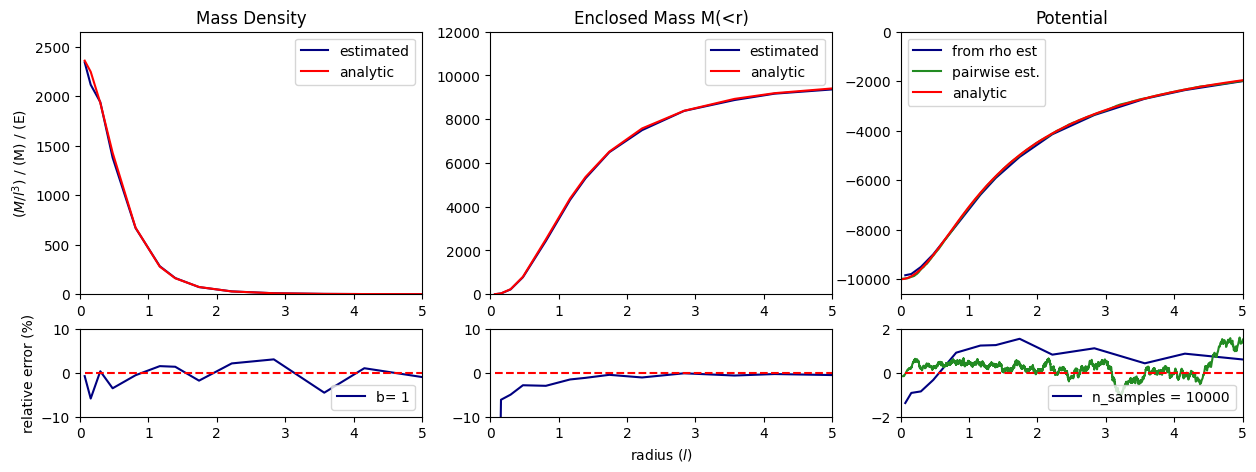

In [32]:
fig, axs = plt.subplots(2,3, gridspec_kw={'height_ratios': [3, 1]})
fig.set_figheight(5)
fig.set_figwidth(15)

xmax = 5* b

axs[0,0].plot(r_center,rho, label ='estimated', color = 'navy')
axs[0,0].plot(r_center,rholytic(n_samples,b,r_center), label = 'analytic',  color = 'r')
axs[0,0].set_ylabel('$(M/l^3)$ / (M) / (E)')
axs[0,0].set_title('Mass Density')
axs[0,0].set_xlim(0,xmax)
axs[0,0].set_ylim(0,15000/np.power(1+b**2,2.5))
axs[0,0].legend()

axs[1,0].plot(r_center,(100*(rho-rholytic(n_samples,b,r_center))/rholytic(n_samples,b,r_center)), color = 'navy', label = 'b= ' + str(b))
axs[1,0].plot(r_center,np.zeros_like(r_center), linestyle = '--', color = 'r')
axs[1,0].set_ylabel('relative error (%)')
axs[1,0].set_xlim(0,xmax)
axs[1,0].set_ylim(-10,10)
axs[1,0].legend(loc = 'lower right')

axs[0,1].plot(r_center,Menc, label ='estimated', color = 'navy')
axs[0,1].plot(r_center,Mlytic(n_samples,b,r_center), label = 'analytic',  color = 'r')
axs[0,1].set_title('Enclosed Mass M(<r)')
axs[0,1].set_xlim(0,xmax)
axs[0,1].set_ylim(0,12000)
axs[0,1].legend()

axs[1,1].plot(r_center,(100*(Menc-Mlytic(n_samples,b,r_center))/Mlytic(n_samples,b,r_center)), color = 'navy')
axs[1,1].plot(r_center,np.zeros_like(r_center), linestyle = '--', color = 'r')
axs[1,1].set_xlabel('radius $(l)$')
axs[1,1].set_xlim(0,xmax)
axs[1,1].set_ylim(-10,10)



axs[0,2].plot(r_center,EPot, label ='from rho est', color = 'navy')
axs[0,2].plot(r_array,sPhi, label ='pairwise est.', color = 'forestgreen')
axs[0,2].plot(r,PE(G,n_samples,b,r_array), label = 'analytic',  color = 'r')
axs[0,2].set_title('Potential')
axs[0,2].set_xlim(0,xmax)
axs[0,2].set_ylim(-15000/np.power(1+b**2,0.5),0)
axs[0,2].legend()


axs[1,2].plot(r_center,(100*(EPot-PE(G,n_samples,b,r_center))/PE(G,n_samples,b,r_center)), color = 'navy' , label ='n_samples = ' + str(n_samples))
axs[1,2].plot(r_array,(100*(sPhi-PE(G,n_samples,b,r_array))/PE(G,n_samples,b,r_array)), color = 'forestgreen')
axs[1,2].plot(r_center,np.zeros_like(r_center), linestyle = '--', color = 'r')
axs[1,2].set_xlim(0,xmax)
axs[1,2].set_ylim(-2,2)
axs[1,2].legend(loc = 'lower right')

#fig.savefig('/Users/andyhicks/DYNAMITE/Film/' + str(j))
#plt.close(fig)